In [1]:
import numpy as np # linear algebra
import os
import cv2
import subprocess
import random
from os.path import join, expanduser, exists
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models._utils as _utils
import torchvision.models.resnet as resnet
import torch.nn.functional as F
import torchvision.ops as ops
from collections import OrderedDict
from torchvision import datasets, models, transforms

In [2]:
batch_size = 8
input_size = 224
margin = 40
frames_per_video=8

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [4]:
class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            # self.pyramid_levels = [2, 3, 4, 5, 6]
            self.pyramid_levels = [3, 4, 5]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            # self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
            self.sizes = [2 ** 4.0, 2 ** 6.0, 2 ** 8.0]
        if ratios is None:
            self.ratios = np.array([1, 1, 1])
        if scales is None:
            # self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
            self.scales = np.array([2 ** 0, 2 ** (1/2.0) , 2 ** 1.0 ])

    def forward(self, image):
       
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(device)

def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([1, 1, 1])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, 1)).T

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K * A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class RegressionTransform(nn.Module):
    def __init__(self,mean=None,std_box=None,std_ldm=None):
        super(RegressionTransform, self).__init__()
        if mean is None:
            self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
        else:
            self.mean = mean
        if std_box is None:
            self.std_box = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
        else:
            self.std_box = std_box
        if std_ldm is None:
            self.std_ldm = (torch.ones(1,10) * 0.1)

    def forward(self,anchors,bbox_deltas,ldm_deltas,img):
        widths  = anchors[:, :, 2] - anchors[:, :, 0]
        heights = anchors[:, :, 3] - anchors[:, :, 1]
        ctr_x   = anchors[:, :, 0] + 0.5 * widths
        ctr_y   = anchors[:, :, 1] + 0.5 * heights

        # Rescale
        ldm_deltas = ldm_deltas * self.std_ldm.to(device)
        bbox_deltas = bbox_deltas * self.std_box.to(device)

        bbox_dx = bbox_deltas[:, :, 0]
        bbox_dy = bbox_deltas[:, :, 1]
        bbox_dw = bbox_deltas[:, :, 2]
        bbox_dh = bbox_deltas[:, :, 3]

        # get predicted boxes
        pred_ctr_x = ctr_x + bbox_dx * widths
        pred_ctr_y = ctr_y + bbox_dy * heights
        pred_w     = torch.exp(bbox_dw) * widths
        pred_h     = torch.exp(bbox_dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        # get predicted landmarks
        pt0_x = ctr_x + ldm_deltas[:,:,0] * widths
        pt0_y = ctr_y + ldm_deltas[:,:,1] * heights
        pt1_x = ctr_x + ldm_deltas[:,:,2] * widths
        pt1_y = ctr_y + ldm_deltas[:,:,3] * heights
        pt2_x = ctr_x + ldm_deltas[:,:,4] * widths
        pt2_y = ctr_y + ldm_deltas[:,:,5] * heights
        pt3_x = ctr_x + ldm_deltas[:,:,6] * widths
        pt3_y = ctr_y + ldm_deltas[:,:,7] * heights
        pt4_x = ctr_x + ldm_deltas[:,:,8] * widths
        pt4_y = ctr_y + ldm_deltas[:,:,9] * heights

        pred_landmarks = torch.stack([
            pt0_x, pt0_y, pt1_x, pt1_y, pt2_x, pt2_y, pt3_x, pt3_y, pt4_x,pt4_y
        ],dim=2)

        # clip bboxes and landmarks
        B,C,H,W = img.shape

        pred_boxes[:,:,::2] = torch.clamp(pred_boxes[:,:,::2], min=0, max=W)
        pred_boxes[:,:,1::2] = torch.clamp(pred_boxes[:,:,1::2], min=0, max=H)
        pred_landmarks[:,:,::2] = torch.clamp(pred_landmarks[:,:,::2], min=0, max=W)
        pred_landmarks[:,:,1::2] = torch.clamp(pred_landmarks[:,:,1::2], min=0, max=H)

        return pred_boxes, pred_landmarks


def nms(boxes,scores,iou_threshold):
    boxes = boxes.cpu().numpy()
    score = scores.cpu().numpy()

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(boxes[index])
        picked_score.append(score[index])
        a=start_x[index]
        b=order[:-1]
        c=start_x[order[:-1]]
        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < iou_threshold)
        order = order[left]

    picked_boxes = torch.Tensor(picked_boxes)
    picked_score = torch.Tensor(picked_score)
    return picked_boxes, picked_score


class ContextModule(nn.Module):
    def __init__(self,in_channels=256):
        super(ContextModule,self).__init__()
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.det_context_conv1 = nn.Sequential(
            nn.Conv2d(in_channels,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(inplace=True)
        )
        self.det_context_conv2 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2)
        )
        self.det_context_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(inplace=True)
        )
        self.det_context_conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2)
        )
        self.det_concat_relu = nn.ReLU(inplace=True)

    def forward(self,x):
        x1 = self.det_conv1(x)
        x_ = self.det_context_conv1(x)
        x2 = self.det_context_conv2(x_)
        x3_ = self.det_context_conv3_1(x_)
        x3 = self.det_context_conv3_2(x3_)

        out = torch.cat((x1,x2,x3),1)
        act_out = self.det_concat_relu(out)

        return act_out

class FeaturePyramidNetwork(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FeaturePyramidNetwork,self).__init__()
        self.lateral_blocks = nn.ModuleList()
        self.context_blocks = nn.ModuleList()
        self.aggr_blocks = nn.ModuleList()
        for i, in_channels in enumerate(in_channels_list):
            if in_channels == 0:
                continue
            lateral_block_module = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            aggr_block_module = nn.Sequential(
                nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            context_block_module = ContextModule(out_channels)
            self.lateral_blocks.append(lateral_block_module)
            self.context_blocks.append(context_block_module)
            if i > 0 :
                self.aggr_blocks.append(aggr_block_module)

        # initialize params of fpn layers
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)

    def forward(self,x):
        names = list(x.keys())
        x = list(x.values())

        last_inner = self.lateral_blocks[-1](x[-1])
        results = []
        results.append(self.context_blocks[-1](last_inner))
        for feature, lateral_block, context_block, aggr_block in zip(
            x[:-1][::-1], self.lateral_blocks[:-1][::-1], self.context_blocks[:-1][::-1], self.aggr_blocks[::-1]
            ):
            if not lateral_block:
                continue
            lateral_feature = lateral_block(feature)
            feat_shape = lateral_feature.shape[-2:]
            inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
            last_inner = lateral_feature + inner_top_down
            last_inner = aggr_block(last_inner)
            results.insert(0, context_block(last_inner))

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])

        return out

class ClassHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(ClassHead,self).__init__()
        self.num_anchors = num_anchors
        self.conv1x1 = nn.Conv2d(inchannels,self.num_anchors*2,kernel_size=(1,1),stride=1,padding=0)
        self.output_act = nn.LogSoftmax(dim=-1)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)
        b, h, w, c = out.shape
        out = out.view(b, h, w, self.num_anchors, 2)
        out = self.output_act(out)

        return out.contiguous().view(out.shape[0], -1, 2)

class BboxHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(BboxHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*4,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)

        return out.contiguous().view(out.shape[0], -1, 4)

class LandmarkHead(nn.Module):
    def __init__(self,inchannels=512,num_anchors=3):
        super(LandmarkHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*10,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)

        return out.contiguous().view(out.shape[0], -1, 10)

class RetinaFace(nn.Module):
    def __init__(self,backbone,return_layers,anchor_nums=3):
        super(RetinaFace,self).__init__()
        # if backbone_name == 'resnet50':
        #     self.backbone = resnet.resnet50(pretrained)
        # self.backbone = resnet.__dict__[backbone_name](pretrained=pretrained)
        # self.return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}
        assert backbone,'Backbone can not be none!'
        assert len(return_layers)>0,'There must be at least one return layers'
        self.body = _utils.IntermediateLayerGetter(backbone, return_layers)
        in_channels_stage2 = 256
        # in_channels_stage2 = 64
        in_channels_list = [
            #in_channels_stage2,
            in_channels_stage2 * 2,
            in_channels_stage2 * 4,
            in_channels_stage2 * 8,
        ]
        out_channels = 256
        self.fpn = FeaturePyramidNetwork(in_channels_list,out_channels)
        # self.ClassHead = ClassHead()
        # self.BboxHead = BboxHead()
        # self.LandmarkHead = LandmarkHead()
        self.ClassHead = self._make_class_head()
        self.BboxHead = self._make_bbox_head()
        self.LandmarkHead = self._make_landmark_head()
        self.anchors = Anchors()
        self.regressBoxes = RegressionTransform()
        self.losslayer = LossLayer()

    def _make_class_head(self,fpn_num=3,inchannels=512,anchor_num=3):
        classhead = nn.ModuleList()
        for i in range(fpn_num):
            classhead.append(ClassHead(inchannels,anchor_num))
        return classhead

    def _make_bbox_head(self,fpn_num=3,inchannels=512,anchor_num=3):
        bboxhead = nn.ModuleList()
        for i in range(fpn_num):
            bboxhead.append(BboxHead(inchannels,anchor_num))
        return bboxhead

    def _make_landmark_head(self,fpn_num=3,inchannels=512,anchor_num=3):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,anchor_num))
        return landmarkhead

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def forward(self,inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        out = self.body(img_batch)
        features = self.fpn(out)

        # bbox_regressions = torch.cat([self.BboxHead(feature) for feature in features.values()], dim=1)
        # ldm_regressions = torch.cat([self.LandmarkHead(feature) for feature in features.values()], dim=1)
        # classifications = torch.cat([self.ClassHead(feature) for feature in features.values()],dim=1)

        bbox_regressions = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features.values())], dim=1)
        ldm_regressions = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features.values())], dim=1)
        classifications = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features.values())],dim=1)

        anchors = self.anchors(img_batch)

        if self.training:
            return self.losslayer(classifications, bbox_regressions,ldm_regressions, anchors, annotations)
        else:
            bboxes, landmarks = self.regressBoxes(anchors, bbox_regressions, ldm_regressions, img_batch)

            return classifications, bboxes, landmarks

In [5]:
def create_retinaface(return_layers,backbone_name='resnet50',anchors_num=3,pretrained=True):
    backbone = torchvision.models.resnet50(pretrained=True)
    # freeze layer1
    for name, parameter in backbone.named_parameters():
        # if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
        #     parameter.requires_grad_(False)
        if name == 'conv1.weight':
            # print('freeze first conv layer...')
            parameter.requires_grad_(False)

    model = RetinaFace(backbone,return_layers,anchor_nums=3)

    return model

    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    return IoU

In [6]:
def filt_IoU(a, b, l):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    ldm_sum = l.sum(dim=1)
    mask = ldm_sum<0
    ldm_mask = torch.ones_like(mask)
    ldm_mask[mask] = -1
    filted_IoU = IoU * ldm_mask.float()

    return IoU, filted_IoU

In [7]:
class LossLayer(nn.Module):
    def __init__(self):
        super(LossLayer, self).__init__()
        self.smoothl1 = nn.SmoothL1Loss()

    def forward(self,classifications,bbox_regressions,ldm_regressions,anchors,annotations):
        batch_size = classifications.shape[0]
        classification_losses = []
        bbox_regression_losses = []
        ldm_regression_losses = []

        anchor = anchors[0, :, :]
        anchor_widths  = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x   = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y   = anchor[:, 1] + 0.5 * anchor_heights

        #temp
        positive_indices_list = []

        for j in range(batch_size):
            classification = classifications[j,:,:]
            bbox_regression = bbox_regressions[j,:,:]
            ldm_regression = ldm_regressions[j,:,:]

            annotation = annotations[j,:,:]
            # annotation = annotation[annotation[:,0] != -1]
            annotation = annotation[annotation[:,0] > 0]
            bbox_annotation = annotation[:,:4]
            ldm_annotation = annotation[:,4:]

            if bbox_annotation.shape[0] == 0:
                bbox_regression_losses.append(torch.tensor(0.,requires_grad=True).to(device))
                classification_losses.append(torch.tensor(0.,requires_grad=True).to(device))
                ldm_regression_losses.append(torch.tensor(0.,requires_grad=True).to(device))

                # temp
                positive_indices_list.append([])

                continue

            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])
            #IoU, filt_iou = filt_IoU(anchors[0, :, :], bbox_annotation, ldm_annotation)

            IoU_max, IoU_argmax = torch.max(IoU, dim=1)

            targets = torch.ones(classification.shape)*-1
            targets = targets.to(device)

            # those whose iou<0.3 have no object
            negative_indices = torch.lt(IoU_max, 0.3)
            targets[negative_indices, :] = 0
            targets[negative_indices, 1] = 1

            # those whose iou>0.5 have object
            positive_indices = torch.ge(IoU_max, 0.5)

            #temp
            positive_indices_list.append(positive_indices)

            num_positive_anchors = positive_indices.sum()

            #keep positive and negative ratios with 1:3
            keep_negative_anchors = num_positive_anchors * 3

            bbox_assigned_annotations = bbox_annotation[IoU_argmax, :]
            ldm_assigned_annotations = ldm_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, 0] = 1

            # ignore targets with no landmarks
            # f_IoU_max ,f_IoU_argmax = torch.max(filt_iou, dim=1)
            # ldm_positive_indices = torch.ge(f_IoU_max, 0.5)

            ldm_sum = ldm_assigned_annotations.sum(dim=1)
            ge0_mask = ldm_sum > 0
            ldm_positive_indices = ge0_mask & positive_indices

            # OHEM
            negative_losses = classification[negative_indices,1] * -1
            sorted_losses, _ = torch.sort(negative_losses, descending=True)
            if sorted_losses.numel() > keep_negative_anchors:
                sorted_losses = sorted_losses[:keep_negative_anchors]
            positive_losses = classification[positive_indices,0] * -1

            focal_loss = False
            # focal loss
            if focal_loss:
                alpha = 0.25
                gamma = 2.0
                alpha_factor = torch.ones(targets.shape).to(device) * alpha

                alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
                focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
                focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

                bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

                cls_loss = focal_weight * bce

                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).to(device))

                classification_losses.append(cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0))
            else:
                if positive_indices.sum() > 0:
                    classification_losses.append(positive_losses.mean() + sorted_losses.mean())
                else:
                    classification_losses.append(torch.tensor(0.,requires_grad=True).to(device))


            # compute bboxes loss
            if positive_indices.sum() > 0:
                # bbox
                bbox_assigned_annotations = bbox_assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths  = bbox_assigned_annotations[:, 2] - bbox_assigned_annotations[:, 0]
                gt_heights = bbox_assigned_annotations[:, 3] - bbox_assigned_annotations[:, 1]
                gt_ctr_x   = bbox_assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y   = bbox_assigned_annotations[:, 1] + 0.5 * gt_heights

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / (anchor_widths_pi + 1e-14)
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / (anchor_heights_pi + 1e-14)
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                bbox_targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                bbox_targets = bbox_targets.t()

                # Rescale
                bbox_targets = bbox_targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).to(device)

                # smooth L1
                # box losses
                bbox_regression_loss = self.smoothl1(bbox_targets,bbox_regression[positive_indices, :])
                bbox_regression_losses.append(bbox_regression_loss)
            else:
                bbox_regression_losses.append(torch.tensor(0.,requires_grad=True).to(device))

            # compute landmarks loss
            if ldm_positive_indices.sum() > 0 :
                ldm_assigned_annotations = ldm_assigned_annotations[ldm_positive_indices, :]

                anchor_widths_l = anchor_widths[ldm_positive_indices]
                anchor_heights_l = anchor_heights[ldm_positive_indices]
                anchor_ctr_x_l = anchor_ctr_x[ldm_positive_indices]
                anchor_ctr_y_l = anchor_ctr_y[ldm_positive_indices]

                l0_x = (ldm_assigned_annotations[:,0] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                l0_y = (ldm_assigned_annotations[:,1] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)
                l1_x = (ldm_assigned_annotations[:,2] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                l1_y = (ldm_assigned_annotations[:,3] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)
                l2_x = (ldm_assigned_annotations[:,4] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                l2_y = (ldm_assigned_annotations[:,5] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)
                l3_x = (ldm_assigned_annotations[:,6] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                l3_y = (ldm_assigned_annotations[:,7] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)
                l4_x = (ldm_assigned_annotations[:,8] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                l4_y = (ldm_assigned_annotations[:,9] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)

                ldm_targets = torch.stack((l0_x,l0_y,l1_x,l1_y,l2_x,l2_y,l3_x,l3_y,l4_x,l4_y))
                ldm_targets = ldm_targets.t()

                # Rescale
                scale = torch.ones(1,10)*0.1
                ldm_targets = ldm_targets/scale.to(device)

                ldm_regression_loss = self.smoothl1(ldm_targets, ldm_regression[ldm_positive_indices, :])
                ldm_regression_losses.append(ldm_regression_loss)
            else:
                ldm_regression_losses.append(torch.tensor(0.,requires_grad=True).to(device))

        return torch.stack(classification_losses), torch.stack(bbox_regression_losses),torch.stack(ldm_regression_losses)


In [8]:
def get_detections(img_batch, model, score_threshold=0.5, iou_threshold=0.5):
    model.eval()
    with torch.no_grad():
        classifications, bboxes, landmarks = model(img_batch)
        batch_size = classifications.shape[0]
        picked_boxes = []
        picked_landmarks = []
        picked_scores = []

        for i in range(batch_size):
            classification = torch.exp(classifications[i,:,:])
            bbox = bboxes[i,:,:]
            landmark = landmarks[i,:,:]

            # choose positive and scores > score_threshold
            scores, argmax = torch.max(classification, dim=1)
            argmax_indice = argmax==0
            scores_indice = scores > score_threshold
            positive_indices = argmax_indice & scores_indice

            scores = scores[positive_indices]

            if scores.shape[0] == 0:
                picked_boxes.append(None)
                picked_landmarks.append(None)
                picked_scores.append(None)
                continue

            bbox = bbox[positive_indices]
            landmark = landmark[positive_indices]

            keep = ops.boxes.nms(bbox, scores, iou_threshold)
            keep_boxes = bbox[keep]
            keep_landmarks = landmark[keep]
            keep_scores = scores[keep]
            keep_scores.unsqueeze_(1)
            picked_boxes.append(keep_boxes)
            picked_landmarks.append(keep_landmarks)
            picked_scores.append(keep_scores)

        return picked_boxes, picked_landmarks, picked_scores

In [90]:
def retina_scan(vid_path, model, num_images=frames_per_video):

    cap = cv2.VideoCapture(vid_path)
    count = 0

    images = []
    crops = []
    scores = []
    areas = []
    print("working: ",end='')
    while (True):
        #if count >= num_images:
        #    print(' done!')
        #    break
        ret, img = cap.read()
        if not ret:
            print(' done!')
            break

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #raw_images.append(img)
        img = torch.from_numpy(img)
        img = img.permute(2,0,1)

        input_img = img.unsqueeze(0).float().to(device)

        picked_boxes, picked_landmarks, picked_scores = get_detections(input_img, model, score_threshold=0.5, iou_threshold=0.3)

        np_img = img.cpu().permute(1,2,0).numpy()
        np_img.astype(int)
        img = np_img.astype(np.uint8)

        for j, boxes in enumerate(picked_boxes):
            if boxes is not None:
                for box, landmark, score in zip(boxes,picked_landmarks[j],picked_scores[j]):
                    if score > 0.98:
                        count += 1
                        bxs = list(box.cpu().numpy().astype(np.int32).ravel())
                        h = bxs[3]-bxs[1]
                        w = bxs[2]-bxs[0]
                        area = h * w
                        y1 = max(bxs[1] - margin, 0)
                        y2 = min(bxs[3] + margin, 1080)
                        x1 = max(bxs[0] - margin, 0)
                        x2 = min(bxs[2] + margin, 1920)
                        crop = img[y1:y2,x1:x2,:]
                        if crop.shape[0] == 0 or crop.shape[1] == 0:
                            #print("Shape 0, skipping")
                            continue
                        images.append(img)
                        crops.append(crop)
                        scores.append(score)
                        areas.append(area)
                        print("!",end='')
                        break

    cap.release()

    a = np.array(areas)
    ind = np.argpartition(a, -8)[-8:]
    
    I = []
    C = []
    for i in ind.tolist():
        I.append(images[i])
        C.append(crops[i])
    del images
    del crops
    del scores
    return I, C, areas

In [14]:
import matplotlib.pyplot as plt

In [10]:
return_layers = {'layer2':1,'layer3':2,'layer4':3}
RetinaFace = create_retinaface(return_layers)

retina_dict = RetinaFace.state_dict()
pre_state_dict = torch.load("/tmp/s3bucket/model.pt", map_location=torch.device(device))
pretrained_dict = {k[7:]: v for k, v in pre_state_dict.items() if k[7:] in retina_dict}
RetinaFace.load_state_dict(pretrained_dict)

RetinaFace = RetinaFace.to(device)

In [91]:
#images, crops, scores, spans = retina_scan('./package.mp4', RetinaFace, 30)
images, crops, areas = retina_scan('./package.mp4', RetinaFace, 30)
print("{} images found".format(len(images)))

working: !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! done!
8 images found


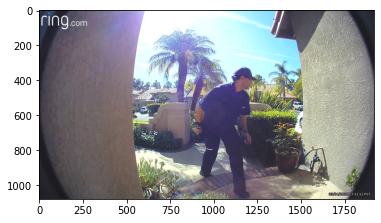

In [106]:
plt.imshow(images[7])

In [107]:
cv2.imwrite('/tmp/s3bucket/pman.jpg', images[7])

True